$$\begin{cases}
    y'' + \sin{y} = 0, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Это уравнение можно свести к системе

$$\begin{cases}
    y' = u \\
    u' = -\sin{y}, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Которая имеет первый интеграл

$$C(y, u) = u^2 - 2\cos{y}$$

Его и будем использовать для проверки точности решения

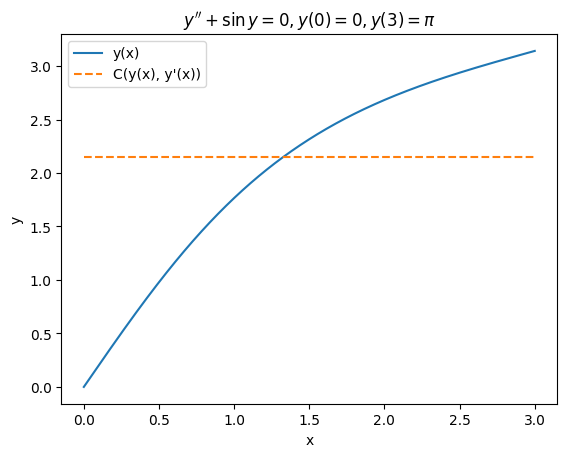

In [44]:
import matplotlib.pyplot as plt
from ODElib import *
from math import *

def f(x, y):
    return Vector(y[1], -sin(y[0]))

def C(y):
    return y[1]*y[1] - 2*cos(y[0])

# only for 2 dimensions
# y' = f(x, (y, u))[0]
# u' = f(x, (y, u))[1]
# y(x1) = y1
# y(x1 + Nh) = y2
class BVPSolver:
    p_eps = 1e-6
    d_eps = 1e-6

    def solve_by_shooting_method(f : VecTFunc, h : float, N: int, y1 : float, y2 : float, x1 : float = 0):
        F = lambda a: RungeKuttaMethods.explicit_4_order(f, Vector(y1, a), h, N, x1)[N][0] - y2
        alpha = 0
        while(True):
            boundary = F(alpha)
            if(abs(boundary) < BVPSolver.p_eps):
                break
            alpha = alpha - boundary / (F(alpha + BVPSolver.d_eps) - boundary) * BVPSolver.d_eps
        return RungeKuttaMethods.explicit_4_order(f, Vector(y1, alpha), h, N, x1)


def show_result(N : int, us : list[float], h : float):
    xs = [h*k for k in range(N + 1)]
    plt.plot(xs, [us[k][0] for k in range(N + 1)], label="y(x)")
    plt.plot(xs, [C(us[k]) for k in range(N + 1)], "--", label="C(y(x), y'(x))")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(r"$y'' + \sin{y} = 0, y(0) = 0, y(3) = \pi$")
    plt.legend()

N = 1000
h = 3 / N

us = BVPSolver.solve_by_shooting_method(f, h, N, 0, pi)
show_result(N, us, h)